In [1]:
#autoreload 
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")
import torch
import lightning as lt
import yaml
from models.CNNAE import AE
import matplotlib.pyplot as plt

ckpt_path = "/home/npopkov/vesuvius_gcml/notebooks/encoder_ckpt/"

encoder_path = ckpt_path + "encoder.pth"
attention_path = ckpt_path + "attention.pth"

aae = AE()
#aae.encoder.load_state_dict(torch.load(encoder_path))
#aae.attention.load_state_dict(torch.load(attention_path))

encoder = aae.encoder
attention = aae.attention



/home/npopkov/vesuvius_gcml/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test = torch.randn(16,16,16,16)
test = torch.nn.ConvTranspose2d(16,1,3,stride=1,padding=1)(test)
test = torch.nn.Flatten()(test)
print(test.shape)

torch.Size([16, 256])


In [3]:
a = torch.randn(16,16, 32, 32)
b = torch.randn(16, 32)
#add all 16 layers of a to b
c = torch.sum(torch.sum(a, dim=1),dim = 2) + b
print(a.shape, b.shape, c.shape)

torch.Size([16, 16, 32, 32]) torch.Size([16, 32]) torch.Size([16, 32])


In [ ]:
from ml.inklabel_dataset import InkLabelDataset
segment_ids = yaml.safe_load(open('../configs/segment_ids.yaml', 'r'))
print(segment_ids['segment_ids'])
segments = [segment_ids['segment_ids']['segments'][0],segment_ids['segment_ids']['segments'][1],segment_ids['segment_ids']['segments'][2]]
SAMPLE_SIZE = 16
VOLUME_DEPTH = 16
dataset = InkLabelDataset(segment_ids=segments,sample_size=SAMPLE_SIZE,volume_depth=VOLUME_DEPTH,upper_bound=.6, lower_bound=0.4)
train, test, val = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])


{'segments': ['20231210121321', '20231106155350', '20231005123336', '20230820203112', '20230620230619', '20230826170124', '20230702185753', '20230522215721', '20230531193658', '20230520175435', '20230903193206', '20230902141231', '20231007101615', '20230929220924', 'recto', 'verso', '20231016151000', '20231012184423', '20231031143850']}
Creating InkLabelDataset with 2 segments...
An error occurred while initializing the Volume class: URL not found for scroll: None, energy: None, resolution: None, segment: 20231106155350
Load the canonical scroll 1 with Volume(type="scroll", scroll_id=1, energy=54, resolution=7.91)
If loading another part of the same physical scroll use for instance Volume(type="scroll", scroll_id="1b", energy=54, resolution=7.91)
Load a segment (e.g. 20230827161847) with Volume(type="segment", scroll_id=1, energy=54, resolution=7.91, segment_id=20230827161847)
Error processing segment 20231106155350: URL not found for scroll: None, energy: None, resolution: None, segme

In [5]:
train_Loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True,num_workers=27)
test_Loader = torch.utils.data.DataLoader(test, batch_size=16, shuffle=False,num_workers=27)
validation_Loader = torch.utils.data.DataLoader(val, batch_size=16, shuffle=False,num_workers=27)

In [6]:
trainer = lt.Trainer(max_epochs=500, accelerator="gpu", devices=1, callbacks=[lt.pytorch.callbacks.early_stopping.EarlyStopping(monitor="train_loss", patience=15, mode="min")])


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/npopkov/vesuvius_gcml/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


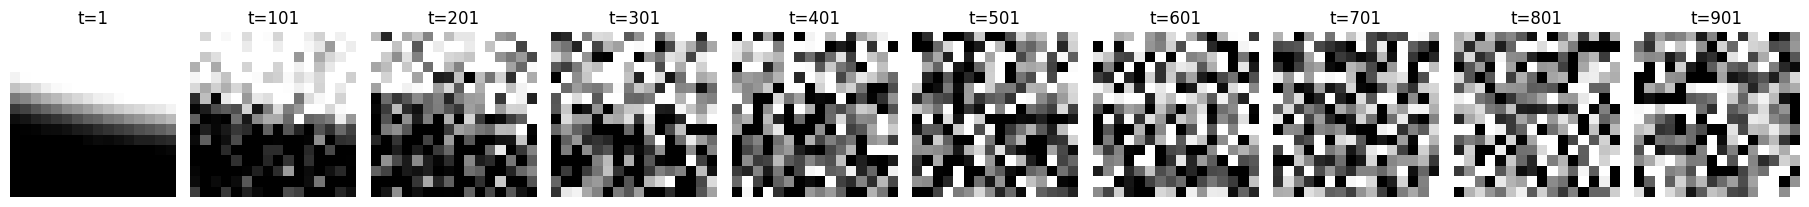

Unique values and their counts:
Value: 0, Count: 40
Value: 6, Count: 1
Value: 9, Count: 1
Value: 10, Count: 1
Value: 13, Count: 1
Value: 15, Count: 1
Value: 18, Count: 1
Value: 19, Count: 1
Value: 20, Count: 2
Value: 26, Count: 1
Value: 27, Count: 2
Value: 30, Count: 2
Value: 32, Count: 1
Value: 36, Count: 1
Value: 37, Count: 1
Value: 39, Count: 1
Value: 41, Count: 1
Value: 43, Count: 1
Value: 46, Count: 1
Value: 48, Count: 2
Value: 50, Count: 2
Value: 51, Count: 1
Value: 57, Count: 2
Value: 59, Count: 1
Value: 61, Count: 1
Value: 62, Count: 1
Value: 63, Count: 1
Value: 65, Count: 2
Value: 68, Count: 2
Value: 69, Count: 1
Value: 73, Count: 1
Value: 74, Count: 2
Value: 75, Count: 1
Value: 77, Count: 3
Value: 79, Count: 1
Value: 80, Count: 2
Value: 82, Count: 1
Value: 84, Count: 1
Value: 85, Count: 2
Value: 86, Count: 1
Value: 90, Count: 1
Value: 91, Count: 2
Value: 92, Count: 1
Value: 95, Count: 2
Value: 98, Count: 1
Value: 100, Count: 2
Value: 104, Count: 3
Value: 107, Count: 2
Value: 

In [ ]:
from models.condDDPM import Diffusion

ddpm = Diffusion(
    noise_steps=1000,
    beta_start=1e-4,
    beta_end=0.03,
    img_size=SAMPLE_SIZE,
    volume_depth=VOLUME_DEPTH,
    c_in=1,
    c_out=1,
    encoder=None,
    attention=None
)

ddpm.plot_test_noising(x=next(iter(train_Loader))['ink_label'][0].float().cuda())

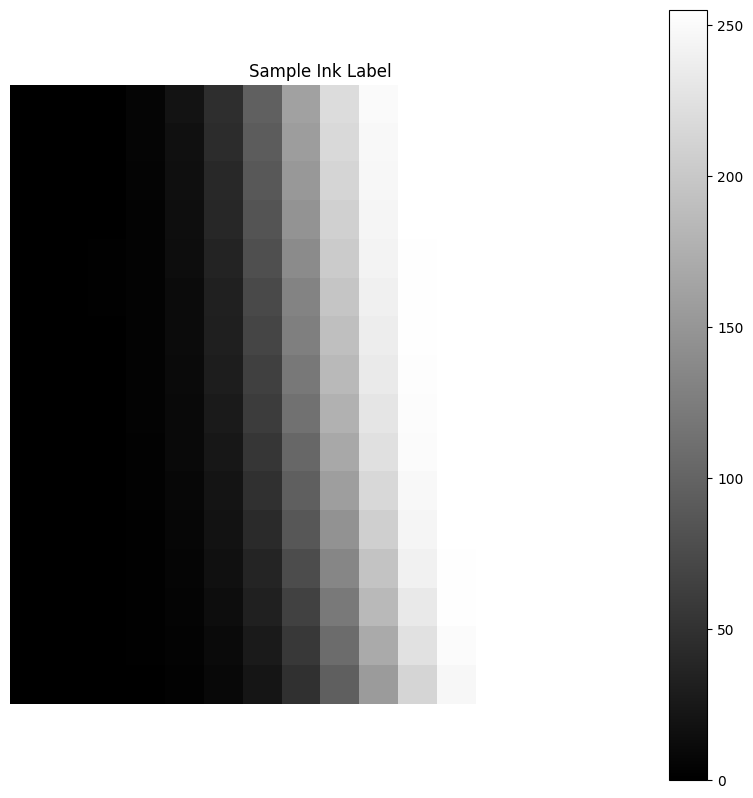

In [8]:
#plot a sample and in each pixel the value of the pixel
x_t = next(iter(train_Loader))['ink_label'].float().cuda()
plt.figure(figsize=(10, 10))
plt.imshow(x_t[0].squeeze().cpu().numpy(), cmap='gray')
plt.colorbar()
plt.title('Sample Ink Label')
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.axis('off')
plt.show()

In [9]:
trainer.fit(ddpm, train_Loader, validation_Loader)

You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | UNet_conditional | 16.0 M | train
---------------------------------------------------
16.0 M    Trainable params
0         Non-trainable params
16.0 M    Total params
63.824    Total estimated model params size (MB)
202       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/npopkov/vesuvius_gcml/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 0: 100%|██████████| 57/57 [00:02<00:00, 24.54it/s, v_num=65]

/home/npopkov/vesuvius_gcml/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 5. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 39: 100%|██████████| 57/57 [00:03<00:00, 14.70it/s, v_num=65]


In [10]:
ddpm.save(model_cpkt_path="/home/npopkov/vesuvius_gcml/notebooks/ddpm_ckpt", model_ckpt="ckpt.pt")

In [11]:
ddpm.load(model_cpkt_path="/home/npopkov/vesuvius_gcml/notebooks/ddpm_ckpt", model_ckpt="ckpt.pt")

Output shape after training: torch.Size([8, 1, 16, 16])


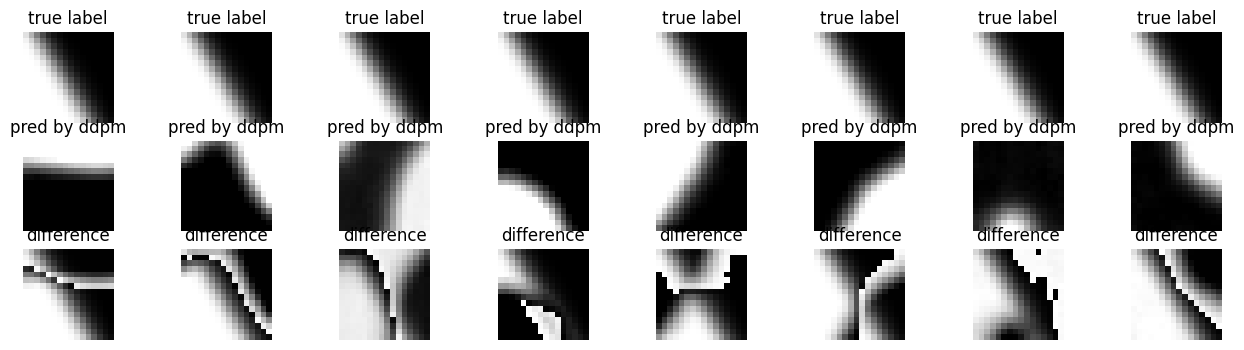

In [12]:
test_sample = next(iter(test_Loader))
idx = 3
#stack the same sample 8 times
input_sample = test_sample['scroll_segment'][idx].repeat(8, 1, 1, 1).float().cuda()
test_results = ddpm.__test_after_training__(input_sample)

plt.figure(figsize=(16, 4))
for i in range(8):
    plt.subplot(3, 8, i + 1)
    plt.imshow(test_sample['ink_label'][idx].cpu().numpy(), cmap='gray',vmin=0,vmax=255)
    plt.axis('off')
    plt.title("true label")

    plt.subplot(3, 8, i + 9)
    plt.imshow(test_results[i][0].cpu().numpy(), cmap='gray',vmin=0,vmax=255)
    plt.axis('off')
    plt.title("pred by ddpm")
    
    plt.subplot(3,8,i+17)
    plt.imshow(test_sample['ink_label'][idx].cpu().numpy()-test_results[i][0].cpu().numpy(),cmap='gray',vmin=0,vmax=255)
    plt.axis('off')
    plt.title('difference')

plt.show()

In [13]:
from ml import matching_pixels, matching_pixels_subset_max

res = matching_pixels(test_sample['ink_label'].cpu().numpy()[0],test_results.squeeze().cpu().numpy()[0])
print(res / (SAMPLE_SIZE**2))

res = matching_pixels_subset_max(test_results.cpu().numpy(),test_sample['ink_label'].squeeze().cpu().numpy()[0])
print(res / (SAMPLE_SIZE**2))

0.7578125


100%|██████████| 8/8 [00:00<00:00, 116508.44it/s]

0.76953125


In [14]:
res = matching_pixels(test_sample['ink_label'].cpu().numpy()[0],test_sample['ink_label'].cpu().numpy()[0])
res

np.int64(0)

# 29.07. 
- vielleicht erstmal 60/40 testen $\checkmark$
- nochmal nach fertigem conditional ddpm scouten
- nochmal den AE besser hinbekommen oder sogar einen VAE probieren
- github.com/lucidrains anschauen
- classifier free guidance
- optuna
- 16 channel auf 1 channel runter für conv2d  $\checkmark$